# AF2 predictions benchmark 

In [162]:
import json
import os
import pandas as pd
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

results_dir = "/home/luisasantus/Desktop/crg_cluster/data/structural_regression/af2_structures/"

In [163]:
def get_plddt(results_dir, dataset):
    colabfold_dir = results_dir+"/colabfold_header/"
    plddt_summary = pd.DataFrame()
    for fam in os.listdir(colabfold_dir):
        fam_dir = os.path.join(colabfold_dir,fam)
        for f in os.listdir(os.path.join(fam_dir,"plddts")):
            if f.endswith('plddt.eval'):
                plddts = pd.read_csv(os.path.join(fam_dir,"plddts",f), sep = "\s+", header = None)
                plddts = plddts.set_axis(["sequence", "plddt"], axis=1)
                plddts["family"] = fam
                plddts["benchmarking_dataset"] = dataset
                
                plddt_summary = pd.concat([plddt_summary, plddts], ignore_index=True)
    return(plddt_summary)

In [164]:
# Extract plddt for each sequence in the family
af2_homfam = get_plddt(results_dir, "homfam")
af2_homfam_summary = af2_homfam.groupby(['family',"benchmarking_dataset"]).agg({'plddt': ['mean', 'min', 'max']}).reset_index().set_axis(["family", "benchmarking_dataset", "plddt_mean", "plddt_min", "plddt_max"], axis=1)
summary_homfam_exthomfam = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_homfam_exthomfam.csv")
summary_homfam_exthomfam = summary_homfam_exthomfam.rename(columns={"dataset": "benchmarking_dataset"})
summary_homfam_exthomfam.head(2)
stats_af2 = pd.merge(af2_homfam_summary, summary_homfam_exthomfam, on =["family","benchmarking_dataset"])
# store files
af2_homfam.to_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/", "02_summary_af2.csv"), index = False)
af2_homfam_summary.to_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/", "03_summary_af2_grouped.csv"), index = False)

# Visualize 

### How well does AF2 perform on the sequences in the families in the different datasets

In [165]:
af2_homfam_summary.head(2)

,family,benchmarking_dataset,plddt_mean,plddt_min,plddt_max
0,Acetyltransf,homfam,78.380506,64.0451,86.1721
1,ChtBD,homfam,67.455496,52.7687,76.0178


In [166]:
len(af2_homfam_summary.family.unique())

73

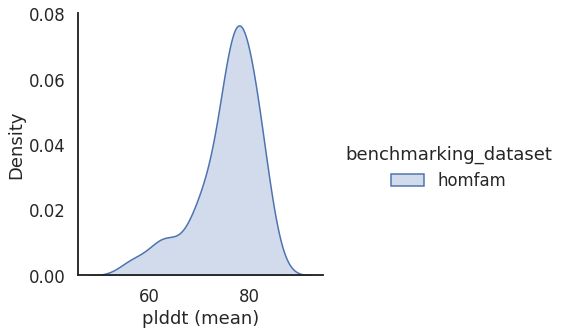

In [167]:
# Plot AF2 plddts summaries across families 
sns.set_theme(style="white")
sns.set_context("talk")
ax = sns.displot(af2_homfam_summary, x="plddt_mean", hue = "benchmarking_dataset", kind="kde", fill = True)
ax.set(xlabel='plddt (mean)')

In [168]:
dataset = "homfam"
seqs_dir="/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/seq_lengths/"+dataset

summary_lengths = pd.DataFrame()
for filename in os.scandir(seqs_dir):
    if filename.is_file():
        summary_fam = pd.read_csv(filename)
        summary_lengths = pd.concat([summary_lengths,summary_fam], ignore_index=True)
        
af2_sequence_summary = pd.merge(af2_homfam, summary_lengths, on =["family","sequence","benchmarking_dataset"])

[Text(0, 0.5, 'sequence length')]

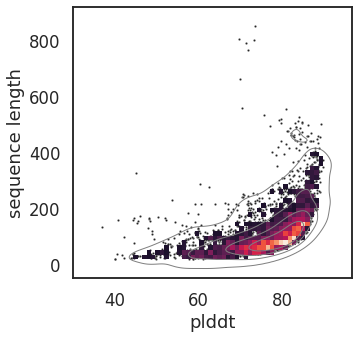

In [169]:
# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(5, 5))
x=af2_sequence_summary.plddt
y=af2_sequence_summary["sequence length"]
sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="rocket")
sns.kdeplot(x=x, y=y, levels=5, color="grey", linewidths=1)
ax.set(ylabel='sequence length')

['n: 3546']


Text(1, 1, "['n: 3546']")

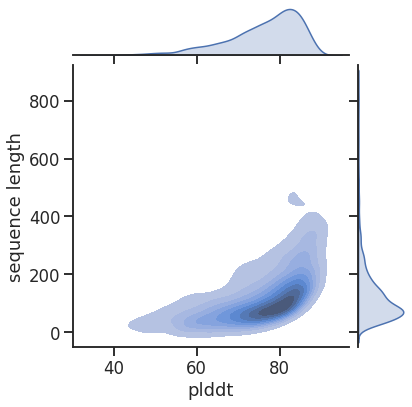

In [170]:
sns.set_theme(style="ticks")
sns.set_context("talk")


sns.jointplot(
    data=af2_sequence_summary,  fill=True, color = "red", legend = False, 
    x="plddt", y="sequence length", hue="benchmarking_dataset",
    kind="kde",
)

nobs = af2_sequence_summary['sequence'].value_counts().sum()
nobs = ["n: " + str(nobs)]
print(nobs)
# Add it to the plot
ax.text(1,1,nobs,horizontalalignment='center',size='small',color='red')


['n: 3546']


Text(1, 1, "['n: 3546']")

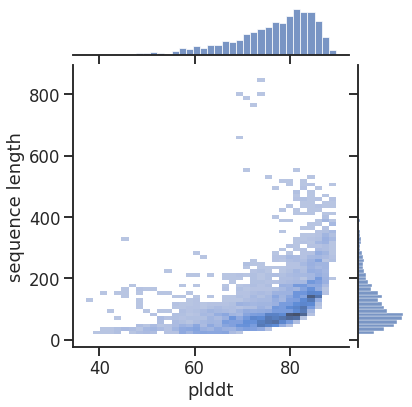

In [171]:
sns.set_theme(style="ticks")
sns.set_context("talk")


sns.jointplot(
    data=af2_sequence_summary,
    x="plddt", y="sequence length",
    kind="hist"
)

nobs = af2_sequence_summary['sequence'].value_counts().sum()
nobs = ["n: " + str(nobs)]
print(nobs)
# Add it to the plot
ax.text(1,1,nobs,horizontalalignment='center',size='small',color='red')



# Running times

In [172]:
import pathlib
structures_dir = "/home/luisasantus/Desktop/crg_cluster/data/structural_regression/af2_structures/colabfold"
sumary_homfam_length = pd.read_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_homfam_length.csv"))

In [173]:
def parse_trace_hash(trace, get_seq_ids = True, get_seq_stats = True):
    nseq = 0
    node_type = ""
    ids = ""
    with open(trace) as fo:
        for line in fo:
            # ----- Sequences 
            if line.startswith('>'):
                nseq += 1
                if(get_seq_ids):
                    id_clean=line.replace(">","").strip().replace("/","_")
                    if(ids ==""):
                        ids = id_clean
                    else:
                        ids+=";"+id_clean
            elif line.startswith('#cpu flag'):
                cpu = line.split("flag")[1]
                if(cpu.strip() == "" ):
                    node_type="gpu"
                else: 
                    node_type="cpu"
            elif line.startswith('real'):
                realtime=line.split(" ")[1].strip()

    df = pd.DataFrame([{"nseq": nseq,
                  "node_type": node_type,
                  "realtime": realtime,
                  "ids": ids     }])
    
    if(get_seq_stats):
        seq_lengths = sumary_homfam_length[sumary_homfam_length.sequence.isin(ids.split(";"))]["sequence length"]
        df["max"] = seq_lengths.max()
        df["mean"] = seq_lengths.mean()
    
    return(df)

In [174]:
# Parse in trace files 
fileExt = r"*hash_colabfold_trace.txt"
traces = pd.DataFrame()
for fam in os.listdir(structures_dir):
        fam_dir = os.path.join(structures_dir,fam)
        if(fam == "test"):
            continue
        for trace in list(pathlib.Path(fam_dir).glob(fileExt)):
            df = parse_trace_hash(trace)
            df["family"] = fam 
            traces = traces.append(df, ignore_index=True)
traces["hours"]=pd.to_numeric(traces.realtime)/3600
traces["nseq"]=pd.to_numeric(traces.nseq)

In [175]:
### Make bins
traces["nseq_range"] = "-"
traces.loc[traces.nseq < 25,"nseq_range"] = "nseq < 25"
traces.loc[traces.nseq == 25,"nseq_range"] = "nseq = 25"
traces.loc[traces.nseq > 25,"nseq_range"] = "25 < nseq <= 50"
traces = traces.sort_values(by =["nseq"])

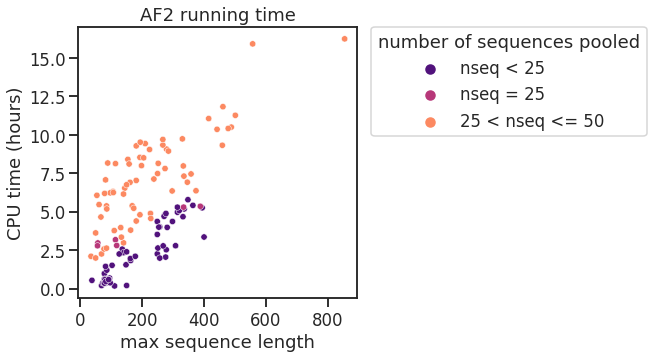

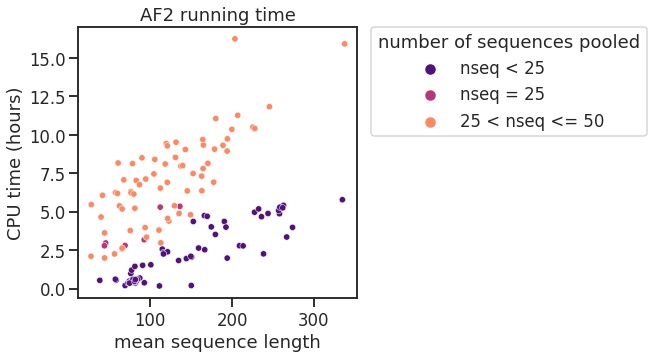

In [176]:
sns.set_context("talk")
metrics = ["max","mean"]
for metric in metrics: 
    f, ax = plt.subplots(figsize=(5, 5))
    sns.scatterplot(data=traces, y="hours", x=metric,
                    hue="nseq_range", s =40, palette = "magma")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = "number of sequences pooled")
    ax.set(ylabel='CPU time (hours)', xlabel= metric +" sequence length", title = "AF2 running time")
    

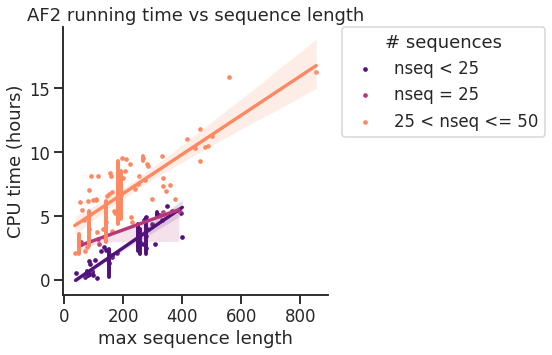

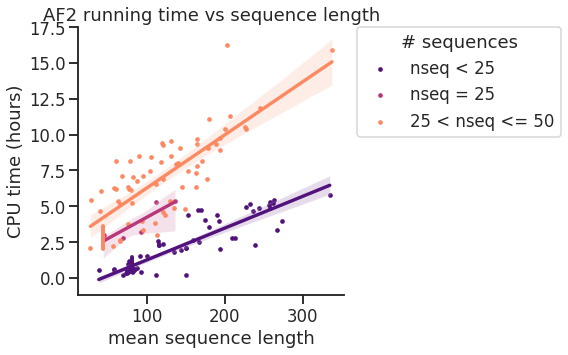

In [177]:
sns.set_context("talk")
for metric in metrics: 
    g = sns.lmplot(y="hours", x=metric,
                 data=traces,hue="nseq_range",
                 palette = "magma", legend = False, 
                 x_estimator=np.mean, scatter_kws={"s": 10})
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = "# sequences")
    g.set(ylabel='CPU time (hours)', xlabel= metric +" sequence length", title = "AF2 running time vs sequence length")


# Same family computed twice, same sequences, very different runtime

<AxesSubplot:xlabel='hours', ylabel='family'>

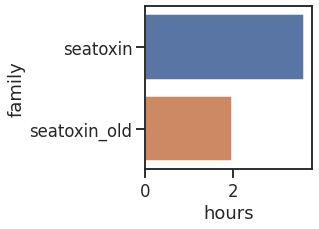

In [178]:
names = ["seatoxin", "seatoxin_old"]
f, ax = plt.subplots(figsize=(3, 3))
sns.barplot(x="hours", y="family", data=traces.loc[traces['family'].isin(names)])